<a href="https://colab.research.google.com/github/aerospaceng25/astrodynamics/blob/master/BMUH565_BusraGUL_2307060010__ipynb_adl%C4%B1_not_defterinin_kopyas%C4%B1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DATA PRE-PROCESSING

In [ ]:
import pandas as pd
import seaborn as sns
import urllib.request
import numpy as np
np.random.seed(1337)  # for reproducibility
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import Normalizer
from keras.models import Sequential
from keras.layers import Convolution1D, Dense, Dropout, Flatten, MaxPooling1D, Activation, Lambda
from keras import callbacks
from keras.layers import LSTM, GRU, SimpleRNN
from sklearn.metrics import (precision_score, recall_score,f1_score, accuracy_score,mean_squared_error,mean_absolute_error, confusion_matrix, ConfusionMatrixDisplay, classification_report )

In [ ]:
# Define the URLs for the training and testing sets from a reliable GitHub mirror
train_url = "https://raw.githubusercontent.com/HoaNP/NSL-KDD-DataSet/master/KDDTrain+.txt"
test_url = "https://raw.githubusercontent.com/HoaNP/NSL-KDD-DataSet/master/KDDTest+.txt"

In [ ]:
# Define the column names (standard 43 columns for NSL-KDD)
columns = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land',
    'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised',
    'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
    'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count',
    'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate',
    'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
    'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
    'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate',
    'attack', 'level'
]

# Load the datasets
print("Downloading and loading datasets...")
traindata = pd.read_csv(train_url, header=None)
testdata = pd.read_csv(test_url, header=None)

# 2. Assign names to your dataframe (assuming it's named 'traindata')
traindata.columns = columns
testdata.columns = columns

In [ ]:
# Display the first few rows
print("Training Data Loaded. Shape:", traindata.shape)
print("Test Data Loaded. Shape:", testdata.shape)
traindata.head()
testdata.head()

Training Data Loaded. Shape: (125973, 123)
Test Data Loaded. Shape: (22544, 117)


,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,True,False,False,False,False,False,False,False,False,False
1,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,True,False,False,False,False,False,False,False,False,False
2,0.000035,2.066513e-04,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,True,False
3,0.000000,3.183413e-07,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,True,False
4,0.000017,0.000000e+00,0.000011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,True,False,False,False,False,False,False,False,False


In [ ]:
# 2. Data Cleaning
# Remove 'level' (difficulty score) as it is not a feature used for detection
traindata.drop('level', axis=1, inplace=True)

# 3. Label Encoding (Binary Classification)
# Transform 'normal' to 0 and any attack type to 1
traindata['attack'] = traindata['attack'].apply(lambda x: 0 if x == 'normal' else 1)

# 4. Categorical Encoding (One-Hot Encoding)
# 'protocol_type', 'service', and 'flag' are non-numeric
traindata = pd.get_dummies(traindata, columns=['protocol_type', 'service', 'flag'])

# 5. Normalization (Min-Max Scaling)
# Identify numerical columns (exclude the target 'attack')
numeric_cols = traindata.select_dtypes(include=['float64', 'int64', 'int32']).columns.tolist()
if 'attack' in numeric_cols:
    numeric_cols.remove('attack')

scaler = MinMaxScaler()
traindata[numeric_cols] = scaler.fit_transform(traindata[numeric_cols])

# Result Summary
print("Preprocessing Complete!")
print(f"New Shape: {traindata.shape}")
print(f"Normal (0) vs Attack (1) counts:\n{traindata['attack'].value_counts()}")
traindata.head()

X = traindata.iloc[:,1:42]
Y = traindata.iloc[:,0]

Preprocessing Complete!
New Shape: (125973, 123)
Normal (0) vs Attack (1) counts:
attack
0    67343
1    58630
Name: count, dtype: int64


In [ ]:
# 2. Data Cleaning
# Remove 'level' (difficulty score) as it is not a feature used for detection
testdata.drop('level', axis=1, inplace=True)

# 3. Label Encoding (Binary Classification)
# Transform 'normal' to 0 and any attack type to 1
testdata['attack'] = testdata['attack'].apply(lambda x: 0 if x == 'normal' else 1)

# 4. Categorical Encoding (One-Hot Encoding)
# 'protocol_type', 'service', and 'flag' are non-numeric
testdata = pd.get_dummies(testdata, columns=['protocol_type', 'service', 'flag'])

# 5. Normalization (Min-Max Scaling)
# Identify numerical columns (exclude the target 'attack')
numeric_cols = testdata.select_dtypes(include=['float64', 'int64', 'int32']).columns.tolist()
if 'attack' in numeric_cols:
    numeric_cols.remove('attack')

scaler = MinMaxScaler()
testdata[numeric_cols] = scaler.fit_transform(testdata[numeric_cols])

# Result Summary
print("Preprocessing Complete!")
print(f"New Shape: {testdata.shape}")
print(f"Normal (0) vs Attack (1) counts:\n{testdata['attack'].value_counts()}")
testdata.head()

C = testdata.iloc[:,0]
T = testdata.iloc[:,1:42]

Preprocessing Complete!
New Shape: (22544, 117)
Normal (0) vs Attack (1) counts:
attack
1    12833
0     9711
Name: count, dtype: int64


In [ ]:
scaler = Normalizer().fit(X)
trainX = scaler.transform(X)

scaler = Normalizer().fit(T)
testT = scaler.transform(T)

In [ ]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(trainX, (trainX.shape[0],trainX.shape[1],1))
X_test = np.reshape(testT, (testT.shape[0],testT.shape[1],1))

y_train = np.array(Y)
y_test = np.array(C)

In [ ]:
# 1. Kategorik sütunları One-Hot Encoding ile genişlet
# Bu işlem sütun sayını 41'den 122'ye çıkaracaktır
X = pd.get_dummies(traindata.drop('attack', axis=1))

# 2. Boyutu kontrol et (Burada 122 görmelisin)
print(f"Veri boyutu: {X.shape}")

# 3. Normalizasyon (Min-Max)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# 4. Modeli bu yeni boyuta göre tanımla veya eğit
# Eğer modeli önceden tanımladıysan, input_dim'in 122 olduğundan emin ol:
input_dim = X_scaled.shape[1]
print(f"Modelin beklediği giriş boyutu: {input_dim}")

# X_scaled ve y (etiketler) verini %80 Eğitim, %20 Test olacak şekilde böl
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

Veri boyutu: (125973, 122)
Modelin beklediği giriş boyutu: 122


# DNN MODEL

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Flatten
from sklearn.model_selection import train_test_split

In [ ]:
# Girdi boyutunu belirleyelim (Normalizasyon sonrası traindata sütun sayısı)
# 'attack' sütununu hedef değişken olarak ayırdığını varsayıyoruz
input_dim = traindata.drop('attack', axis=1).shape[1]

In [ ]:
model = Sequential([
    # 1. Girdi ve Dense Layer (Örn: 64 nöron)
    Dense(64, input_dim=input_dim, activation='relu'),

    # 2. Batch Normalization
    # Eğitimi stabilize eder ve hızlandırır
    BatchNormalization(),

    # 3. Dropout
    # %20 oranında nöronu rastgele kapatarak overfitting'i önler
    Dropout(0.2),

    # 4. Flatten
    # Not: Veri zaten 1D olduğu için teknik olarak çıktı değişmez ama isteğin üzerine ekliyoruz
    Flatten(),

    # 5. Son Dense Layer (Output)
    # İkili sınıflandırma (Normal vs Attack) için 1 nöron ve sigmoid
    Dense(1, activation='sigmoid')
])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Modeli Derleme
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 64)             │         7,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,193 (32.00 KB)

 Trainable params: 8,065 (31.50 KB)

 Non-trainable params: 128 (512.00 B)

In [ ]:
# 1. Kategorik sütunları One-Hot Encoding ile genişlet
# Bu işlem sütun sayını 41'den 122'ye çıkaracaktır
X = pd.get_dummies(traindata.drop('attack', axis=1))

# 2. Boyutu kontrol et (Burada 122 görmelisin)
print(f"Veri boyutu: {X.shape}")

# 3. Normalizasyon (Min-Max)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# 4. Modeli bu yeni boyuta göre tanımla veya eğit
# Eğer modeli önceden tanımladıysan, input_dim'in 122 olduğundan emin ol:
input_dim = X_scaled.shape[1]
print(f"Modelin beklediği giriş boyutu: {input_dim}")

# X_scaled ve y (etiketler) verini %80 Eğitim, %20 Test olacak şekilde böl
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

Veri boyutu: (125973, 122)
Modelin beklediği giriş boyutu: 122


In [ ]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9705 - loss: 0.0901 - val_accuracy: 0.9870 - val_loss: 0.0420
Epoch 2/10
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9854 - loss: 0.0421 - val_accuracy: 0.9887 - val_loss: 0.0306
Epoch 3/10
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9883 - loss: 0.0332 - val_accuracy: 0.9927 - val_loss: 0.0240
Epoch 4/10
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9894 - loss: 0.0299 - val_accuracy: 0.9940 - val_loss: 0.0224
Epoch 5/10
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9903 - loss: 0.0283 - val_accuracy: 0.9934 - val_loss: 0.0231
Epoch 6/10
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.9910 - loss: 0.0273 - val_accuracy: 0.9935 - val_loss: 0.0202
Epoch 7/10
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9917 - loss: 0.0249 - val_accuracy: 0.9929 - val_loss: 0.0234
Epoch 8/10
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9920 - loss: 0.0235 - 

In [ ]:
# Eğitim bittikten sonra modelin hiç görmediği X_test ile başarıyı ölç:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Başarımı (Accuracy): {test_acc}")

788/788 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9924 - loss: 0.0259
Test Başarımı (Accuracy): 0.9919825196266174


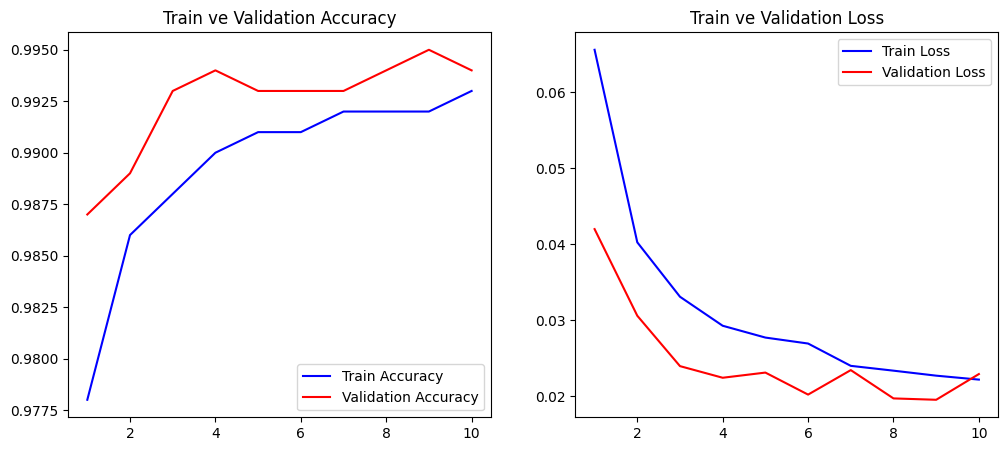

In [ ]:
#evaluation metrics
acc_ = history.history['accuracy']
acc = [round(num, 3) for num in acc_]
val_acc_ = history.history['val_accuracy']
val_acc = [round(num, 3) for num in val_acc_]
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))

# Accuracy Grafiği
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Train Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Train ve Validation Accuracy')
plt.legend()

# Loss Grafiği
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Train Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Train ve Validation Loss')
plt.legend()

plt.show()

788/788 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


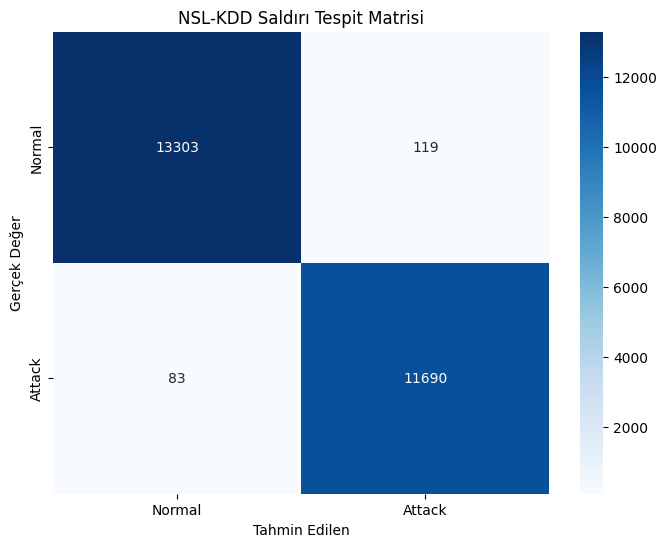


--- Sınıflandırma Raporu ---
              precision    recall  f1-score   support

      Normal       0.99      0.99      0.99     13422
      Attack       0.99      0.99      0.99     11773

    accuracy                           0.99     25195
   macro avg       0.99      0.99      0.99     25195
weighted avg       0.99      0.99      0.99     25195



In [ ]:
# 1. Tahminleri Al
# Model sigmoid kullandığı için sonuçlar 0 ile 1 arasında olasılıktır.
# 0.5'ten büyükse 1 (Saldırı), küçükse 0 (Normal) kabul ediyoruz.
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype("int32")

# 2. Confusion Matrix Hesapla
cm = confusion_matrix(y_test, y_pred)

# 3. Görselleştirme
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Attack'],
            yticklabels=['Normal', 'Attack'])

plt.title('NSL-KDD Saldırı Tespit Matrisi')
plt.ylabel('Gerçek Değer')
plt.xlabel('Tahmin Edilen')
plt.show()

# 4. Detaylı Metrik Raporu
print("\n--- Sınıflandırma Raporu ---")
print(classification_report(y_test, y_pred, target_names=['Normal', 'Attack']))

# RNN MODEL

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, BatchNormalization, Dropout

In [ ]:
# Veriyi (Örnek Sayısı, 1, 122) formatına getiriyoruz
X_train_rnn = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test_rnn = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

print(f"RNN Giriş Boyutu: {X_train_rnn.shape}")

RNN Giriş Boyutu: (100778, 1, 122)


In [ ]:
model_rnn = Sequential([
    # 1. Simple RNN Katmanı
    # input_shape=(zaman_adımı, özellik_sayısı)
    SimpleRNN(128, input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2]), activation='relu'),

    # 2. Batch Normalization
    BatchNormalization(),

    # 3. Dropout
    Dropout(0.2),

    # 4. Dense (Output) Katmanı
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Modeli Derleme
model_rnn.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

In [ ]:
model_rnn.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_1 (SimpleRNN)        │ (None, 128)            │        32,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,769 (128.00 KB)

 Trainable params: 32,513 (127.00 KB)

 Non-trainable params: 256 (1.00 KB)

In [ ]:
history_rnn = model_rnn.fit(
    X_train_rnn, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2
)

Epoch 1/10
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - accuracy: 0.9935 - loss: 0.0204 - val_accuracy: 0.9940 - val_loss: 0.0179
Epoch 2/10
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.9934 - loss: 0.0196 - val_accuracy: 0.9940 - val_loss: 0.0172
Epoch 3/10
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9940 - loss: 0.0168 - val_accuracy: 0.9948 - val_loss: 0.0166
Epoch 4/10
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9942 - loss: 0.0165 - val_accuracy: 0.9947 - val_loss: 0.0164
Epoch 5/10
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9942 - loss: 0.0169 - val_accuracy: 0.9946 - val_loss: 0.0167
Epoch 6/10
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9938 - loss: 0.0194 - val_accuracy: 0.9950 - val_loss: 0.0163
Epoch 7/10
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.9948 - loss: 0.0165 - val_accuracy: 0.9951 - val_loss: 0.0154
Epoch 8/10
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9943 - loss: 0.

In [ ]:
# 1. Test seti üzerinde genel başarıyı ölç
test_loss, test_acc = model_rnn.evaluate(X_test_rnn, y_test, verbose=0)
print(f"RNN Modeli Test Doğruluğu (Accuracy): %{test_acc*100:.2f}")

RNN Modeli Test Doğruluğu (Accuracy): %99.31


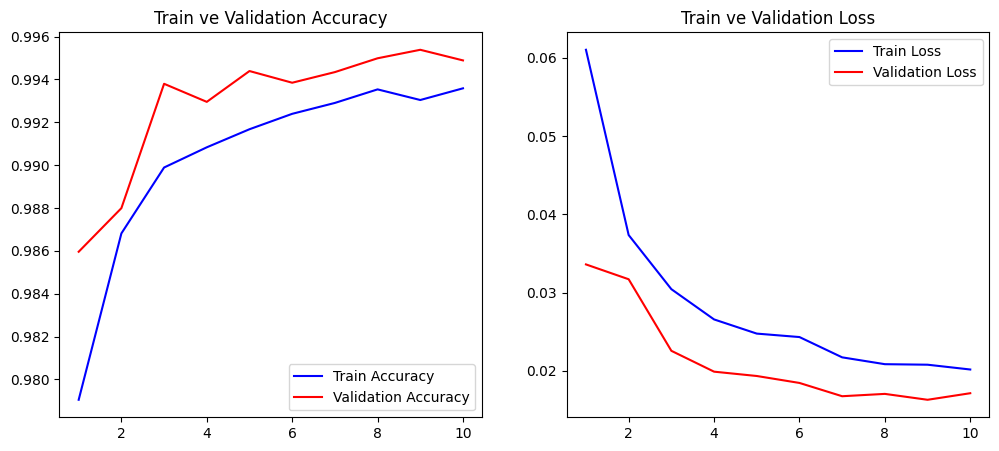

In [ ]:
#evaluation metrics
acc = history_rnn.history['accuracy']
#acc = [round(num, 3) for num in acc_]
val_acc = history_rnn.history['val_accuracy']
#val_acc = [round(num, 3) for num in val_acc_]
loss = history_rnn.history['loss']
val_loss = history_rnn.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))

# Accuracy Grafiği
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Train Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Train ve Validation Accuracy')
plt.legend()

# Loss Grafiği
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Train Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Train ve Validation Loss')
plt.legend()

plt.show()

788/788 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


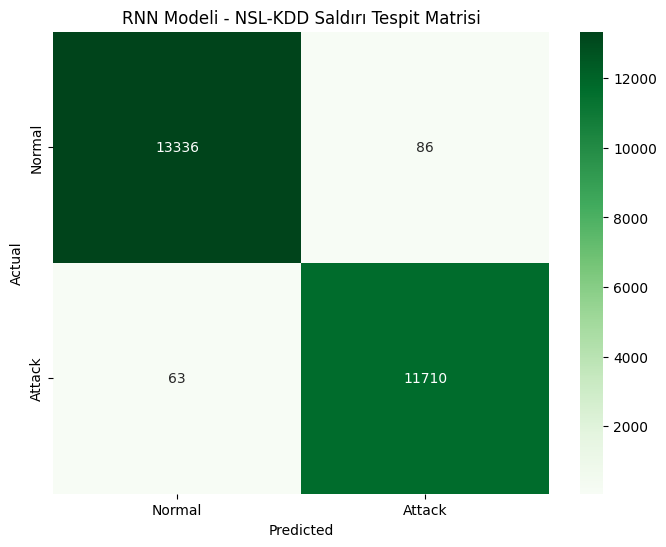


--- Classification Report ---
              precision    recall  f1-score   support

      Normal       1.00      0.99      0.99     13422
      Attack       0.99      0.99      0.99     11773

    accuracy                           0.99     25195
   macro avg       0.99      0.99      0.99     25195
weighted avg       0.99      0.99      0.99     25195



In [ ]:
# 1. Tahminleri Al
# Model sigmoid kullandığı için sonuçlar 0 ile 1 arasında olasılıktır.
# 0.5'ten büyükse 1 (Saldırı), küçükse 0 (Normal) kabul ediyoruz.
y_pred_probs_rnn = model_rnn.predict(X_test_rnn)
y_pred_rnn = (y_pred_probs_rnn > 0.5).astype("int32")

# 2. Confusion Matrix Hesapla
cm_rnn = confusion_matrix(y_test, y_pred_rnn)

# 3. Görselleştirme
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rnn, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Normal', 'Attack'],
            yticklabels=['Normal', 'Attack'])

plt.title('RNN Modeli - NSL-KDD Saldırı Tespit Matrisi')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# 4. Detaylı Metrik Raporu
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred_rnn, target_names=['Normal', 'Attack']))

# CNN MODEL

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, BatchNormalization, Dropout, Flatten, Dense

In [ ]:
# Veriyi (Örnek Sayısı, 1, 122) formatına getiriyoruz
X_train_cnn = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test_cnn = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print(f"CNN Giriş Boyutu: {X_train_cnn.shape}")

CNN Giriş Boyutu: (100778, 122, 1)


In [ ]:
model_cnn = Sequential([
    # 1. Conv1D Katmanı
    # 32 filtre, 3'lük pencere boyutu (kernel_size)
    Conv1D(filters=32, kernel_size=2, activation='relu', input_shape=(X_train_cnn.shape[1], 1)),

    # 2. MaxPooling Katmanı
    # En belirgin özellikleri seçer ve boyutu yarıya indirir
    MaxPooling1D(pool_size=2),

    # 3. Batch Normalization
    BatchNormalization(),

    # 4. Dropout
    Dropout(0.2),

    # 5. Flatten
    # Matrisi vektöre dönüştürür
    Flatten(),

    # 6. Dense (Output) Katmanı
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Modeli Derleme
model_cnn.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

In [ ]:
model_cnn.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_5 (Conv1D)               │ (None, 121, 32)        │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 60, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 60, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 60, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 1920)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │         1,921 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,145 (8.38 KB)

 Trainable params: 2,081 (8.13 KB)

 Non-trainable params: 64 (256.00 B)

In [ ]:
history_cnn = model_cnn.fit(
    X_train_cnn, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2
)

Epoch 1/10
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - accuracy: 0.9769 - loss: 0.0603 - val_accuracy: 0.9814 - val_loss: 0.0473
Epoch 2/10
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.9806 - loss: 0.0537 - val_accuracy: 0.9796 - val_loss: 0.0506
Epoch 3/10
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.9813 - loss: 0.0516 - val_accuracy: 0.9830 - val_loss: 0.0468
Epoch 4/10
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.9818 - loss: 0.0526 - val_accuracy: 0.9811 - val_loss: 0.0489
Epoch 5/10
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - accuracy: 0.9806 - loss: 0.0543 - val_accuracy: 0.9834 - val_loss: 0.0444
Epoch 6/10
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - accuracy: 0.9810 - loss: 0.0518 - val_accuracy: 0.9808 - val_loss: 0.0465
Epoch 7/10
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.9812 - loss: 0.0525 - val_accuracy: 0.9831 - val_loss: 0.0436
Epoch 8/10
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.9811 - loss: 

In [ ]:
# 1. Test seti üzerinde genel başarıyı ölç
test_loss, test_acc = model_cnn.evaluate(X_test_cnn, y_test, verbose=0)
print(f"CNN Modeli Test Doğruluğu (Accuracy): %{test_acc*100:.2f}")

CNN Modeli Test Doğruluğu (Accuracy): %98.33


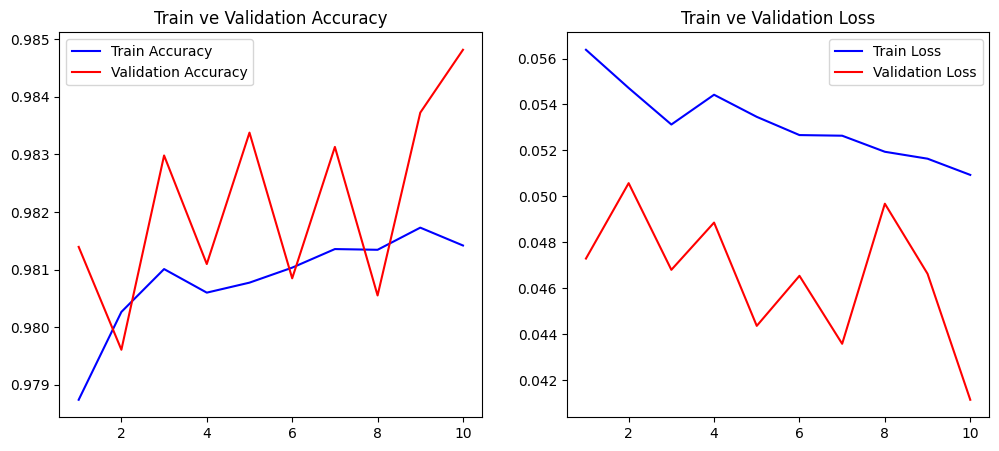

In [ ]:
#evaluation metrics
acc = history_cnn.history['accuracy']
#acc = [round(num, 3) for num in acc_]
val_acc = history_cnn.history['val_accuracy']
#val_acc = [round(num, 3) for num in val_acc_]
loss = history_cnn.history['loss']
val_loss = history_cnn.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))

# Accuracy Grafiği
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Train Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Train ve Validation Accuracy')
plt.legend()

# Loss Grafiği
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Train Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Train ve Validation Loss')
plt.legend()

plt.show()

788/788 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


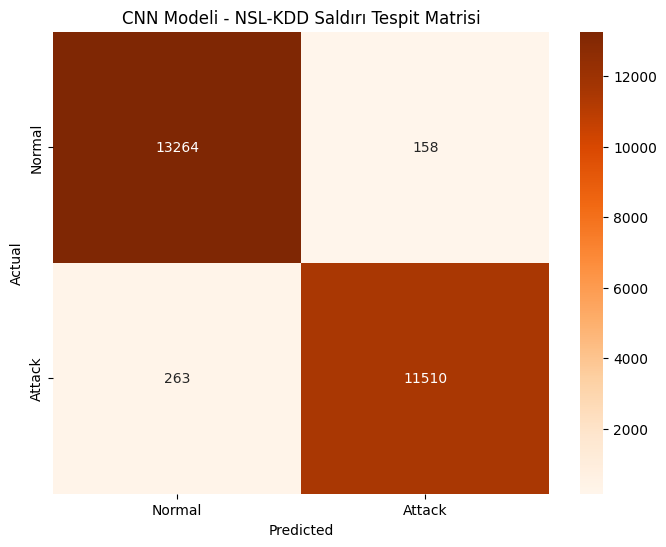


--- Classification Report ---
              precision    recall  f1-score   support

      Normal       0.98      0.99      0.98     13422
      Attack       0.99      0.98      0.98     11773

    accuracy                           0.98     25195
   macro avg       0.98      0.98      0.98     25195
weighted avg       0.98      0.98      0.98     25195



In [ ]:
# 1. Tahminleri Al
# Model sigmoid kullandığı için sonuçlar 0 ile 1 arasında olasılıktır.
# 0.5'ten büyükse 1 (Saldırı), küçükse 0 (Normal) kabul ediyoruz.
y_pred_probs_cnn = model_cnn.predict(X_test_cnn)
y_pred_cnn = (y_pred_probs_cnn > 0.5).astype("int32")

# 2. Confusion Matrix Hesapla
cm_cnn = confusion_matrix(y_test, y_pred_cnn)

# 3. Görselleştirme
plt.figure(figsize=(8, 6))
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['Normal', 'Attack'],
            yticklabels=['Normal', 'Attack'])

plt.title('CNN Modeli - NSL-KDD Saldırı Tespit Matrisi')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# 4. Detaylı Metrik Raporu
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred_cnn, target_names=['Normal', 'Attack']))

# LSTM MODEL

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization, Dropout

In [ ]:
# Veriyi (Örnek Sayısı, 1, 122) formatına getiriyoruz
X_train_lstm = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

print(f"LSTM Giriş Boyutu: {X_train_lstm.shape}")

LSTM Giriş Boyutu: (100778, 1, 122)


In [ ]:
model_lstm = Sequential([
    # 1. LSTM Katmanı
    # 64 ünite ile verideki karmaşık ilişkileri öğrenir
    LSTM(64, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), activation='tanh'),

    # 2. Batch Normalization
    BatchNormalization(),

    # 3. Dropout
    Dropout(0.3),

    # 4. Dense (Output) Katmanı
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Modeli Derleme
model_lstm.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

In [ ]:
model_lstm.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 64)             │        47,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,193 (188.25 KB)

 Trainable params: 48,065 (187.75 KB)

 Non-trainable params: 128 (512.00 B)

In [ ]:
history_lstm = model_lstm.fit(
    X_train_lstm, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2
)

Epoch 1/10
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.9756 - loss: 0.0715 - val_accuracy: 0.9815 - val_loss: 0.0497
Epoch 2/10
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.9814 - loss: 0.0534 - val_accuracy: 0.9808 - val_loss: 0.0425
Epoch 3/10
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.9834 - loss: 0.0499 - val_accuracy: 0.9861 - val_loss: 0.0380
Epoch 4/10
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9858 - loss: 0.0423 - val_accuracy: 0.9895 - val_loss: 0.0299
Epoch 5/10
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.9870 - loss: 0.0385 - val_accuracy: 0.9920 - val_loss: 0.0282
Epoch 6/10
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - accuracy: 0.9890 - loss: 0.0331 - val_accuracy: 0.9928 - val_loss: 0.0240
Epoch 7/10
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.9896 - loss: 0.0318 - val_accuracy: 0.9939 - val_loss: 0.0226
Epoch 8/10
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.9908 - loss: 0

In [ ]:
# 1. Test seti üzerinde genel başarıyı ölç
test_loss, test_acc = model_lstm.evaluate(X_test_lstm, y_test, verbose=0)
print(f"LSTM Modeli Test Doğruluğu (Accuracy): %{test_acc*100:.2f}")

LSTM Modeli Test Doğruluğu (Accuracy): %99.29


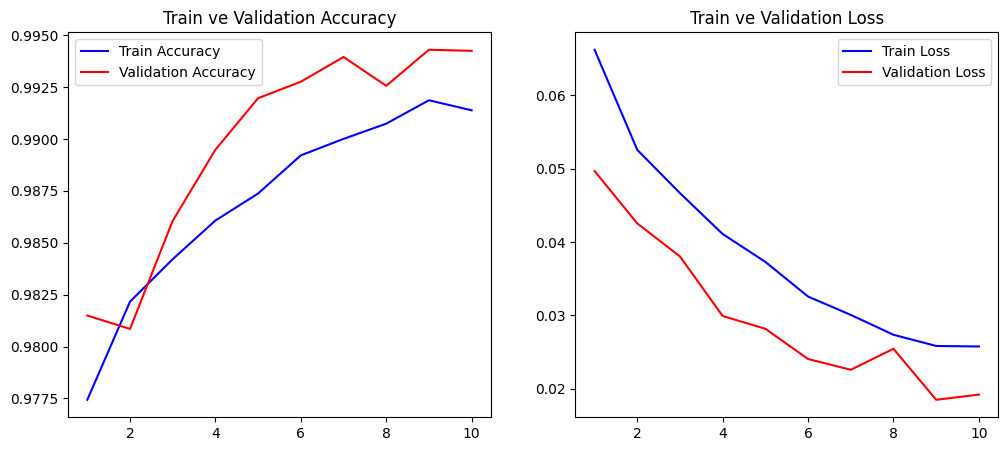

In [ ]:
#evaluation metrics
acc = history_lstm.history['accuracy']
#acc = [round(num, 3) for num in acc_]
val_acc = history_lstm.history['val_accuracy']
#val_acc = [round(num, 3) for num in val_acc_]
loss = history_lstm.history['loss']
val_loss = history_lstm.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))

# Accuracy Grafiği
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Train Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Train ve Validation Accuracy')
plt.legend()

# Loss Grafiği
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Train Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Train ve Validation Loss')
plt.legend()

plt.show()

788/788 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


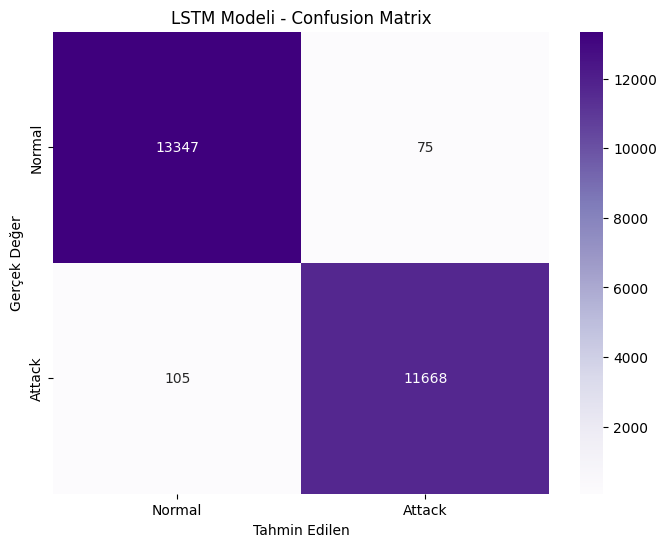

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     13422
           1       0.99      0.99      0.99     11773

    accuracy                           0.99     25195
   macro avg       0.99      0.99      0.99     25195
weighted avg       0.99      0.99      0.99     25195



In [ ]:
# Tahminleri al ve yuvarla
y_pred_lstm = (model_lstm.predict(X_test_lstm) > 0.5).astype("int32")

# Matrisi hesapla
cm_lstm = confusion_matrix(y_test, y_pred_lstm)

# Görselleştir
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Purples',
            xticklabels=['Normal', 'Attack'],
            yticklabels=['Normal', 'Attack'])

plt.title('LSTM Modeli - Confusion Matrix')
plt.ylabel('Gerçek Değer')
plt.xlabel('Tahmin Edilen')
plt.show()

print(classification_report(y_test, y_pred_lstm))

# CNN + LSTM MODEL

In [ ]:
lstm_output_size = 70

model = Sequential()
model.add(Convolution1D(64, 2 ,activation="relu",input_shape=(41, 1)))
model.add(MaxPooling1D(pool_size=(2)))
model.add(LSTM(lstm_output_size))
model.add(Dropout(0.2))
model.add(Dense(1, activation="sigmoid"))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_10 (Conv1D)              │ (None, 40, 64)         │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_10 (MaxPooling1D) │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 70)             │        37,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 70)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1)              │            71 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,063 (148.68 KB)

 Trainable params: 38,063 (148.68 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 120s 48ms/step - accuracy: 0.9703 - loss: 0.1054 - val_accuracy: 0.9718 - val_loss: 0.0967
Epoch 2/10
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 118s 47ms/step - accuracy: 0.9747 - loss: 0.0922 - val_accuracy: 0.9525 - val_loss: 0.1381
Epoch 3/10
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 117s 46ms/step - accuracy: 0.9770 - loss: 0.0844 - val_accuracy: 0.9777 - val_loss: 0.0831
Epoch 4/10
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 116s 46ms/step - accuracy: 0.9793 - loss: 0.0747 - val_accuracy: 0.9815 - val_loss: 0.0725
Epoch 5/10
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 118s 47ms/step - accuracy: 0.9805 - loss: 0.0700 - val_accuracy: 0.9793 - val_loss: 0.0696
Epoch 6/10
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 115s 46ms/step - accuracy: 0.9811 - loss: 0.0635 - val_accuracy: 0.9831 - val_loss: 0.0542
Epoch 7/10
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 143s 46ms/step - accuracy: 0.9829 - loss: 0.0531 - val_accuracy: 0.9816 - val_loss: 0.0456
Epoch 8/10
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 116s 46ms/step - accuracy: 

In [ ]:
# Eğitim bittikten sonra modelin hiç görmediği X_test ile başarıyı ölç:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Başarımı (Accuracy): {test_acc}")

788/788 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.9915 - loss: 0.0295
Test Başarımı (Accuracy): 0.9907521605491638


In [ ]:
#np.savetxt('res/expected1.txt', y_test, fmt='%01d')
#np.savetxt('res/predicted1.txt', y_pred, fmt='%01d')

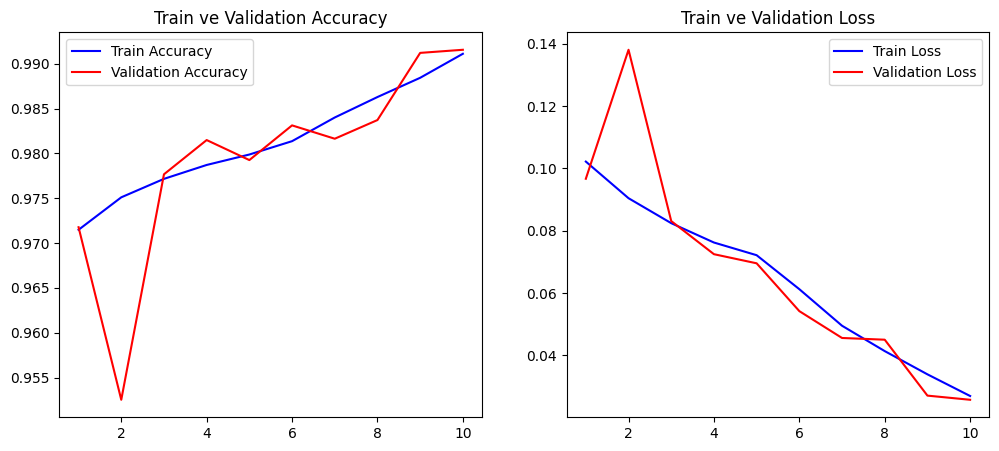

In [ ]:
#evaluation metrics
acc = history.history['accuracy']
#acc = [round(num, 3) for num in acc_]
val_acc = history.history['val_accuracy']
#val_acc = [round(num, 3) for num in val_acc_]
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))

# Accuracy Grafiği
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Train Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Train ve Validation Accuracy')
plt.legend()

# Loss Grafiği
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Train Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Train ve Validation Loss')
plt.legend()

plt.show()

In [ ]:
# 1. Tahminleri al (0.0 - 1.0 arası olasılıklar)
y_pred_probs = model.predict(X_test)

# 2. Olasılıkları Binary (0 veya 1) formatına çevir
# 0.5'ten büyükse 1, değilse 0
y_pred = (y_pred_probs > 0.5).astype("int32")


788/788 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step


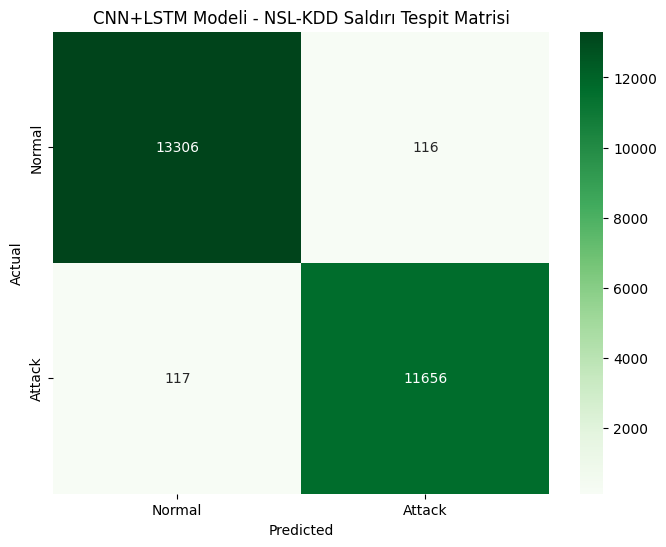


--- Classification Report ---
              precision    recall  f1-score   support

      Normal       0.99      0.99      0.99     13422
      Attack       0.99      0.99      0.99     11773

    accuracy                           0.99     25195
   macro avg       0.99      0.99      0.99     25195
weighted avg       0.99      0.99      0.99     25195



In [ ]:
# 3. Şimdi Confusion Matrix hesapla (Hata almayacaksın)
cm = confusion_matrix(y_test, y_pred)

# 3. Görselleştirme
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Normal', 'Attack'],
            yticklabels=['Normal', 'Attack'])

plt.title('CNN+LSTM Modeli - NSL-KDD Saldırı Tespit Matrisi')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# 4. Detaylı Metrik Raporu
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred, target_names=['Normal', 'Attack']))

# CNN + RNN HYBRID MODEL

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, BatchNormalization, Dropout

In [ ]:
# Veriyi (Örnek Sayısı, 122, 1) formatına getiriyoruz
X_train_hybrid = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test_hybrid = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print(f"CNN + RNN Hibrit Model Giriş Boyutu: {X_train_hybrid.shape}")

CNN + RNN Hibrit Model Giriş Boyutu: (100778, 122, 1)


In [ ]:
model_hybrid = Sequential([
    # 1. Conv1D Layer (Başlangıç)
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(122, 1)),

    # 2. MaxPooling Layer
    MaxPooling1D(pool_size=2),

    # 3. Batch Normalization & Dropout
    BatchNormalization(),
    Dropout(0.3),

    # 4. LSTM Layer
    # Not: CNN çıktısı otomatik olarak 3D olduğu için LSTM ile doğrudan bağlanabilir
    LSTM(64, activation='tanh'),

    # 5. Batch Normalization & Dropout
    BatchNormalization(),
    Dropout(0.3),

    # 6. Dense (Output) Layer
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Modeli Derleme
model_hybrid.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

In [ ]:
model_hybrid.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_11 (Conv1D)              │ (None, 120, 32)        │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_11 (MaxPooling1D) │ (None, 60, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 60, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 60, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 64)             │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,409 (99.25 KB)

 Trainable params: 25,217 (98.50 KB)

 Non-trainable params: 192 (768.00 B)

In [ ]:
history_hybrid = model_hybrid.fit(
    X_train_hybrid, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2
)

Epoch 1/10
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 123s 49ms/step - accuracy: 0.9654 - loss: 0.1136 - val_accuracy: 0.9759 - val_loss: 0.0752
Epoch 2/10
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 138s 47ms/step - accuracy: 0.9737 - loss: 0.0833 - val_accuracy: 0.9684 - val_loss: 0.0888
Epoch 3/10
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 118s 47ms/step - accuracy: 0.9786 - loss: 0.0666 - val_accuracy: 0.9868 - val_loss: 0.0414
Epoch 4/10
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 118s 47ms/step - accuracy: 0.9835 - loss: 0.0517 - val_accuracy: 0.9800 - val_loss: 0.0577
Epoch 5/10
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 118s 47ms/step - accuracy: 0.9858 - loss: 0.0427 - val_accuracy: 0.9899 - val_loss: 0.0297
Epoch 6/10
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 122s 48ms/step - accuracy: 0.9880 - loss: 0.0368 - val_accuracy: 0.9921 - val_loss: 0.0240
Epoch 7/10
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 120s 48ms/step - accuracy: 0.9897 - loss: 0.0332 - val_accuracy: 0.9925 - val_loss: 0.0247
Epoch 8/10
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 116s 46ms/step - accuracy: 

In [ ]:
# Eğitim bittikten sonra modelin hiç görmediği X_test ile başarıyı ölç:
test_loss, test_acc = model_hybrid.evaluate(X_test_hybrid, y_test)
print(f"Test Başarımı (Accuracy): {test_acc}")

788/788 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.9922 - loss: 0.0263
Test Başarımı (Accuracy): 0.9928954243659973


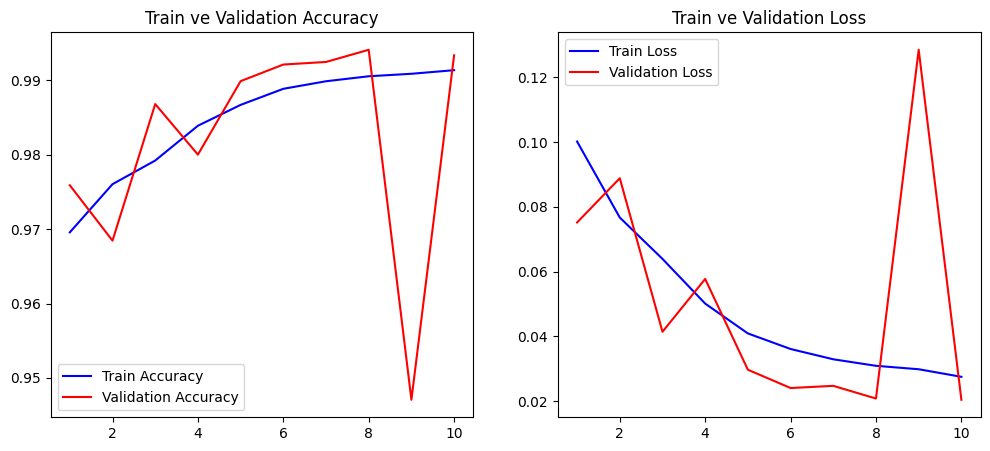

In [ ]:
#evaluation metrics
acc = history_hybrid.history['accuracy']
#acc = [round(num, 3) for num in acc_]
val_acc = history_hybrid.history['val_accuracy']
#val_acc = [round(num, 3) for num in val_acc_]
loss = history_hybrid.history['loss']
val_loss = history_hybrid.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))

# Accuracy Grafiği
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Train Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Train ve Validation Accuracy')
plt.legend()

# Loss Grafiği
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Train Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Train ve Validation Loss')
plt.legend()

plt.show()

788/788 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step


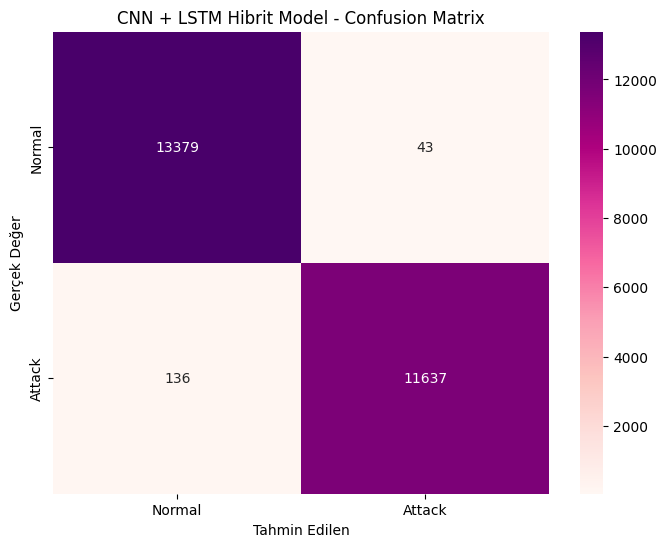

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     13422
           1       1.00      0.99      0.99     11773

    accuracy                           0.99     25195
   macro avg       0.99      0.99      0.99     25195
weighted avg       0.99      0.99      0.99     25195



In [ ]:
# Tahminleri al ve binary formatına çevir
y_pred_hybrid = (model_hybrid.predict(X_test_hybrid) > 0.5).astype("int32")

# Matrisi hesapla
cm_hybrid = confusion_matrix(y_test, y_pred_hybrid)

# Görselleştir
plt.figure(figsize=(8, 6))
sns.heatmap(cm_hybrid, annot=True, fmt='d', cmap='RdPu',
            xticklabels=['Normal', 'Attack'],
            yticklabels=['Normal', 'Attack'])

plt.title('CNN + LSTM Hibrit Model - Confusion Matrix')
plt.ylabel('Gerçek Değer')
plt.xlabel('Tahmin Edilen')
plt.show()

print(classification_report(y_test, y_pred_hybrid))